<a href="https://colab.research.google.com/github/martinpius/Computer-Vission/blob/main/Customized_Tensorbord_for_keras_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on CoLaB with tensorflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n...load your drive please...")
  COLAB = False
def time_fmt(t:float = 123.9187)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"
print(f"...testing time...testing time....\nloading: please wait...\n>>>time elapse: {time_fmt()}")


Mounted at /content/drive/
You are on CoLaB with tensorflow version: 2.4.1
...testing time...testing time....
loading: please wait...
>>>time elapse: 0: 02: 03.00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os, datetime, sys, os, time
import numpy as np

In [3]:
#Load data from tensorflow datasets:

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete7E4FNP/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete7E4FNP/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

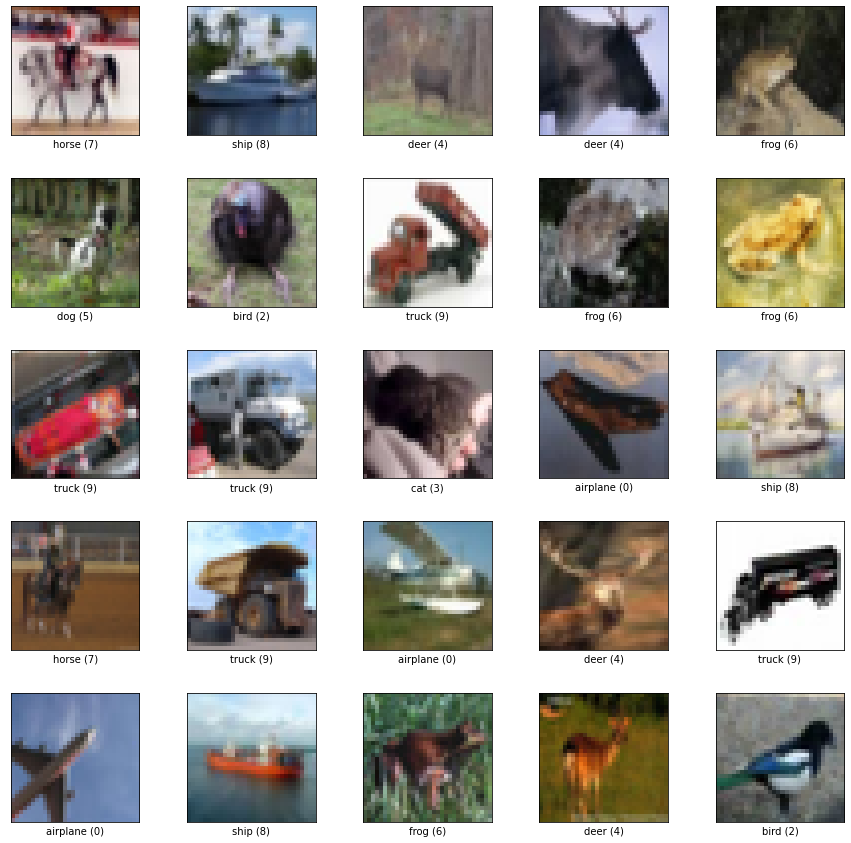

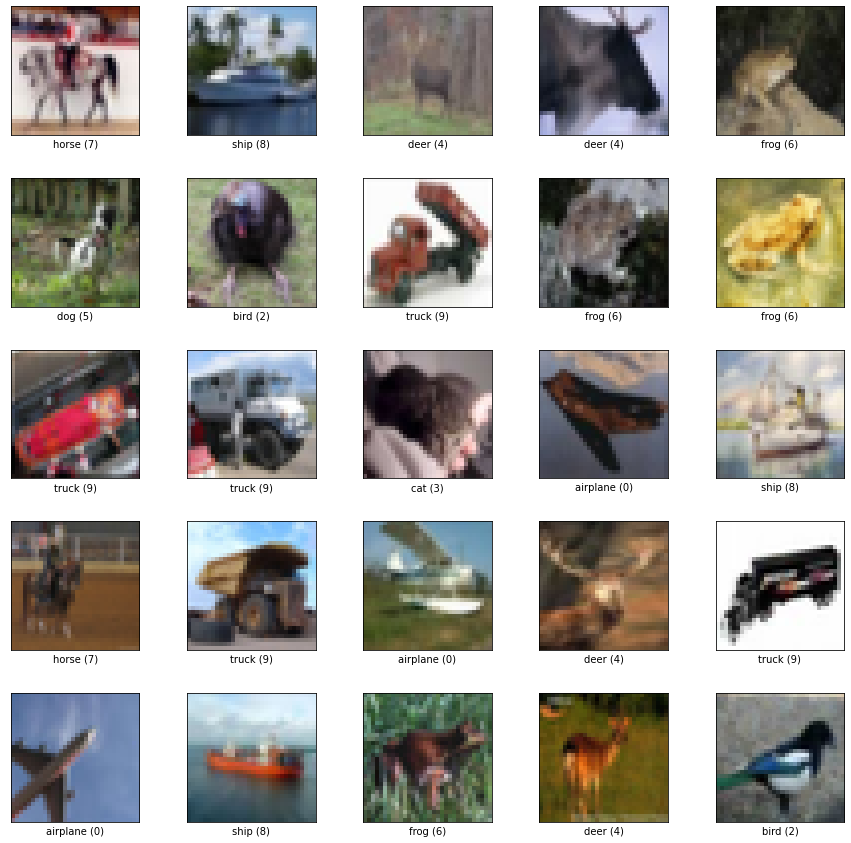

In [4]:
(train_ds, test_ds), info_ds = tfds.load(
    name = 'cifar10',
    split = ['train', 'test'],
    as_supervised = True,
    with_info = True,
    shuffle_files = True
)
display(info_ds)
#plot some few samples from the train dataset:
fig = tfds.show_examples(train_ds, info_ds, rows = 5, cols = 5)
display(fig)

In [5]:
#Preprocess the data:
def normalize_images(image, label):
  return tf.cast(image, tf.float32)/255.0, label

def data_aug(image, label):
  if tf.random.uniform((), minval = 0, maxval = 1) < 0.1:
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1,1,3])
  image = tf.image.flip_left_right(image)
  image = tf.image.adjust_brightness(image, delta = 0.1)
  image = tf.image.adjust_contrast(image, 2)
  return image, label

In [6]:
#prepare training and validation data:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_ds.map(normalize_images, num_parallel_calls = AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(info_ds.splits['train'].num_examples)
train_data = train_data.map(data_aug)
train_data = train_data.batch(batch_size = BATCH_SIZE, drop_remainder = True)
train_data = train_data.prefetch(AUTOTUNE)
test_data = test_ds.map(normalize_images, num_parallel_calls = AUTOTUNE)
test_data = test_data.batch(batch_size = BATCH_SIZE, drop_remainder = True)


In [7]:
#Lets buid a simple resnet from scratch

In [8]:
class MyReLu(tf.keras.layers.Layer):
  def __init__(self, name = 'my_customized_relu', *args, **kwargs):
    super(MyReLu, self).__init__(name = name, *args, **kwargs)
  def custom_relu(self, inputs_tensor):
    return tf.math.maximum(o, inputs_tensor)

In [9]:
class CnnBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, kernel = 3, *args, **kwargs):
    super(CnnBlock, self).__init__(*args, **kwargs)
    self.conv = keras.layers.Conv2D(filters = num_filters, kernel_size = kernel, padding = 'same')
    self.bn = keras.layers.BatchNormalization()
    self.myrelu = MyReLu()
  def call(self, inputs_tensor, training = False):
    x = self.conv(inputs_tensor, training = training)
    x = self.myrelu(x)
    x = self.bn(x)
    return x


In [10]:
class ResNetBlock(keras.layers.Layer):
  def __init__(self, num_filters, *args, **kwargs):
    super(ResNetBlock, self).__init__(*args, **kwargs)
    self.resbl_1 = CnnBlock(num_filters = num_filters[0], name = 'resbl_1')
    self.resbl_2 = CnnBlock(num_filters = num_filters[1], name = 'resbl_2')
    self.resbl_3 = CnnBlock(num_filters = num_filters[2], name = 'resbl_3')
    self.maxpool = keras.layers.MaxPooling2D()
    self.id_mapping = keras.layers.Conv2D(filters = num_filters[1], kernel_size = 3, padding = 'same', activation = 'relu')
  def call(self, inputs_tensor, training = False):
    x = self.resbl_1(inputs_tensor, training = training)
    x = self.resbl_2(x, training = training)
    x = self.resbl_3(x + self.id_mapping(inputs_tensor), training = training)
    x = self.maxpool(x)
    return x

In [11]:
class ResNetModel(keras.models.Model):
  def __init__(self, num_classes = 10, *args, **kwargs):
    super(ResNetModel, self).__init__(self,*args, **kwargs)
    self.block_1 = ResNetBlock([23,64,128], name = 'block_1')
    self.block_2 = ResNetBlock([64,128,256], name = 'block_2')
    self.block_3 = ResNetBlock([128,256,512], name = 'block_3')
    self.block_4 = ResNetBlock([32,64,128], name = 'block_4')
    self.glb = keras.layers.GlobalAveragePooling2D()
    self.dense_1 = keras.layers.Dense(units = 1024, activation = 'relu', name = 'dense_1')
    self.drp_1 = keras.layers.Dropout(rate = 0.25, name = 'dropout1')
    self.dense_2 = keras.layers.Dense(units = 512, activation = 'relu', name = 'dense_2')
    self.drp_2 = keras.layers.Dropout(rate = 0.5, name = 'dropout2')
    self.dense_3 = keras.layers.Dense(units = 128, activation = 'relu', name = 'dense_3')
    self.dense_4 = keras.layers.Dense(units = 64, activation = 'relu', name = 'dense_4')
    self.outputs = keras.layers.Dense(units = 10,name = 'outputs')
  def call(self, inputs_tensor, training = False):
    x = self.block_1(inputs_tensor, training = training)
    x = self.block_2(x, training = training)
    x = self.block_3(x, training = training)
    x = self.block_4(x, training = training)
    x = self.glb(x)
    x = self.dense_1(x, training = training)
    x = self.drp_1(x)
    x = self.dense_2(x, training = training)
    x = self.drp_2(x)
    x = self.dense_3(x, training = training)
    x = self.dense_4(x, training = training)
    x = self.outputs(x, training = training)
    return x


In [12]:
class_names = [
    "Airplane",
    "Autmobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

In [13]:
#instantiating the model:
model = ResNetModel()

In [14]:
#Training the model with the customized training loop and tensorbord:

In [15]:
epochs = 1
tic = time.time()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = keras.optimizers.RMSprop(learning_rate = 0.001)
train_metric = keras.metrics.SparseCategoricalAccuracy()
eval_metric = keras.metrics.SparseCategoricalAccuracy()
train_writer = tf.summary.create_file_writer('/logs/train')
test_writer = tf.summary.create_file_writer('/logs/test')
train_step = test_step = 0

In [17]:
for lr in [1e-1,1e-2,1e-3,1e-4,1e-5]:
  train_step = test_step = 0
  print(f"training begin in a moment for 1 epoch:\n>>>loading....\nplease wait...\n>>>results are suppressed")
  train_writer = tf.summary.create_file_writer('/logs/train' + str(lr))
  test_writer = tf.summary.create_file_writer('/logs/test' + str(lr))
  optimizer = keras.optimizers.RMSprop(learning_rate = lr)
  model = model
  for (step, (x_train_batch, y_train_batch)) in enumerate(train_data):
    with tf.GradientTape() as tape:
      preds = model(x_train_batch, training = True)
      train_loss = loss_fn(y_train_batch, preds)
    grads = tape.gradient(train_loss, model.trainable_weights)
    train_metric.update_state(y_train_batch, preds)
    train_acc = train_metric.result()
    with train_writer.as_default():
      tf.summary.scalar('Loss', train_loss, step = train_step)
      tf.summary.scalar('Accuracy', train_acc, step = train_step)
      train_step+=1
    train_metric.reset_states()
  for (step, (x_val_batch, y_val_batch)) in enumerate(test_data):
    preds = model(x_val_batch, training = False)
    eval_loss = loss_fn(y_val_batch, preds)
    eval_metric.update_state(y_val_batch, preds)
    eval_acc = eval_metric.result()
    with test_writer.as_default():
      tf.summary.scalar('Loss', eval_loss, step = test_step)
      tf.summary.scalar('Accuracy', eval_acc, step = test_step)
      test_step+=1
    eval_metric.reset_states()

toc = time.time()
print(model.summary())
print(f"\ntotal training and evaluation time:\n>>>>{time_fmt(toc - tic)}")


training begin in a moment for 1 epoch:
>>>loading....
please wait...
>>>results are suppressed
training begin in a moment for 1 epoch:
>>>loading....
please wait...
>>>results are suppressed
training begin in a moment for 1 epoch:
>>>loading....
please wait...
>>>results are suppressed
training begin in a moment for 1 epoch:
>>>loading....
please wait...
>>>results are suppressed
training begin in a moment for 1 epoch:
>>>loading....
please wait...
>>>results are suppressed
Model: "res_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block_1 (ResNetBlock)        multiple                  90464     
_________________________________________________________________
block_2 (ResNetBlock)        multiple                  592192    
_________________________________________________________________
block_3 (ResNetBlock)        multiple                  2364032   
___________________________________